In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [168]:
links = pd.read_csv('../data/WBSFLIX/links.csv', index_col='movieId')
movies = pd.read_csv('../data/WBSFLIX/movies.csv', index_col='movieId')
ratings = pd.read_csv('../data/WBSFLIX/ratings.csv')
tags = pd.read_csv('../data/WBSFLIX/tags.csv')

In [169]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


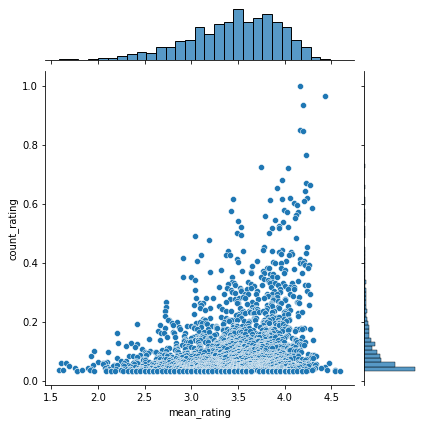

In [180]:
mean_movie_rating = (ratings
                     .groupby('movieId')
                     .agg(mean_rating = ('rating', 'mean'))
                     .sort_values('mean_rating', ascending=False)
                    )
count_movie_ratings = (ratings
                     .groupby('movieId')
                     .agg(count_ratings = ('rating', 'count'))
                     .sort_values('count_ratings', ascending=False)
                    )

#sns.jointplot(x = mean_movie_rating['mean_rating'], y = count_movie_ratings['count_ratings'])
sns.jointplot(x = pop_recom['mean_rating'], y = pop_recom['count_rating']/pop_recom['count_rating'].max())

In [172]:
def get_movie_titles(recommendations: pd.DataFrame, movies: pd.DataFrame) -> list:
    return movies.loc[recommendations.index].title.tolist()

def popularity_based_recommender(ratings: pd.DataFrame, min_n_ratings: int=10) -> pd.DataFrame:
    recommendations = (
        ratings
        .groupby('movieId')
        .agg(
            mean_rating = ('rating', 'mean'),
            count_rating = ('rating', 'count')
        )
        .reset_index()
        .sort_values('mean_rating', ascending=False)
        .query('count_rating > @min_n_ratings')
        .set_index('movieId')
        )
    
    # Weight recommendations wrt the max number of ratings per movie
    recommendations = recommendations.assign(rating=recommendations.mean_rating*(recommendations.count_rating/recommendations.count_rating.max()))
    return recommendations.sort_values('rating', ascending=False).head(5)

def suggest_popular_movies(ratings: pd.DataFrame, movies: pd.DataFrame):
    pop_recom = popularity_based_recommender(ratings)

    print('Here are some popular movies you might enjoy!\n')
    for movie in get_movie_titles(pop_recom, movies):
        print(movie)
    print('\n')
    
def get_most_recent_high_rated_movie(user_id: int, ratings: pd.DataFrame) -> pd.Series:
    return ratings[ratings.userId==user_id].sort_values(['rating', 'timestamp'], ascending=False)['movieId'].head(1)

def correlation_based_recommender(recent_movie_id: int, ratings: pd.DataFrame) -> pd.Series:
    ratings_matrix = ratings.pivot('userId', 'movieId', 'rating')
    recommendations = ratings_matrix.corrwith(ratings_matrix[recent_movie_id]).sort_values(ascending=False).head(5)
    return recommendations

def suggest_movies_correlated_to_last_liked_movie(ratings, movies, user_id):
    recent_movie = get_most_recent_high_rated_movie(user_id, ratings)
    corr_recom = correlation_based_recommender(recent_movie.values[0], ratings)
    
    print(f'Since you liked {get_movie_titles(recent_movie, movies)[0]} you may also like:\n')
    for movie in get_movie_titles(corr_recom, movies):
        print(movie)

def chat_bot(ratings, movies):
    print("Welcome to WBSFLIX! I am your personal movie recommender.\n")
    suggest_popular_movies(ratings, movies)
    
    user_id = int(input())
    
    suggest_movies_correlated_to_last_liked_movie(ratings, movies, user_id)
    
chat_bot(ratings, movies)

Welcome to WBSFLIX! I am your personal movie recommender.

Here are some popular movies you might enjoy!

Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Matrix, The (1999)
Silence of the Lambs, The (1991)




 2


Since you liked Kiss of Death (1995) you may also like:

Holy Man (1998)
Principal, The (1987)
Monster's Ball (2001)
Crossroads (2002)
Six Degrees of Separation (1993)


In [162]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity

def collaboration_based_recommender(user_id: int, ratings: pd.DataFrame) -> pd.Series:
    ratings_similitude = pd.DataFrame(1-cosine_distances(ratings_matrix.fillna(0)), columns=ratings_matrix.index, index=ratings_matrix.index)
    ratings_similitude = pd.DataFrame(cosine_similarity(ratings_matrix.fillna(0)), columns=ratings_matrix.index, index=ratings_matrix.index)
    
    return ratings_similitude

# def suggest_movies_correlated_to_similar_users(ratings, movies, user_id):
#     collab_recom = collaboration_based_recommender(user_id, ratings)

#     print(f'Here are some recommendations just for you!\n')
#     for movie in get_movie_titles(collab_recom, movies):
#         print(movie)

# suggest_movies_correlated_to_similar_users(ratings, movies, user_id=1)

ratings_similitude = collaboration_based_recommender(user_id, ratings)
ratings_similitude

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


In [166]:
def get_movie_titles(recommendations: pd.DataFrame, movies: pd.DataFrame) -> list:
    return movies.loc[recommendations.index].title.tolist()

def popularity_based_recommender(ratings: pd.DataFrame, min_n_ratings: int=10) -> pd.DataFrame:
    recommendations = (
        ratings
        .groupby('movieId')
        .agg(
            mean_rating = ('rating', 'mean'),
            count_rating = ('rating', 'count')
        )
        .reset_index()
        .sort_values('mean_rating', ascending=False)
        .query('count_rating > @min_n_ratings')
        .set_index('movieId')
        )
    recommendations = recommendations.assign(rating=recommendations.mean_rating*(np.log(recommendations.count_rating/recommendations.count_rating.max())))
    return recommendations.sort_values('rating', ascending=False)

def suggest_popular_movies(ratings: pd.DataFrame, movies: pd.DataFrame):
    pop_recom = popularity_based_recommender(ratings)
    
    print(pop_recom)
    
    print('Here are some popular movies you might enjoy!\n')
    for movie in get_movie_titles(pop_recom.head(5), movies):
        print(movie)
    print('\n')
    
    return pop_recom

pop_recom = suggest_popular_movies(ratings, movies)



         mean_rating  count_rating     rating
movieId                                      
356         4.164134           329   0.000000
318         4.429022           317  -0.164565
296         4.197068           307  -0.290479
593         4.161290           279  -0.685972
2571        4.192446           278  -0.706162
...              ...           ...        ...
28          4.227273            11 -14.364960
2360        4.458333            12 -14.762215
1178        4.541667            12 -15.038145
3451        4.545455            11 -15.446193
1041        4.590909            11 -15.600655

[2121 rows x 3 columns]
Here are some popular movies you might enjoy!

Forrest Gump (1994)
Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Matrix, The (1999)




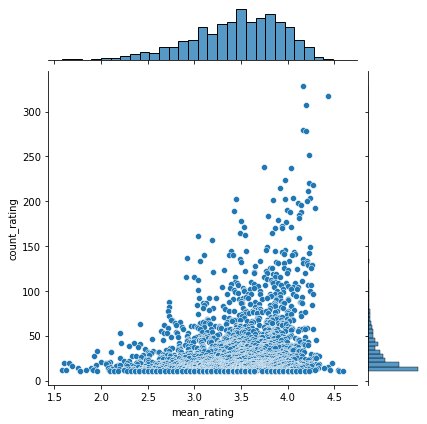

In [175]:
sns.jointplot(x = pop_recom['mean_rating'], y = pop_recom['count_rating']/pop_recom['count_rating'].max())

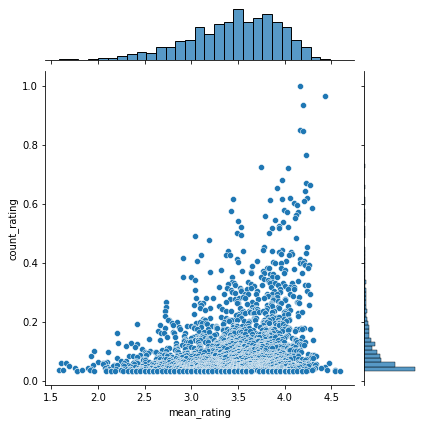

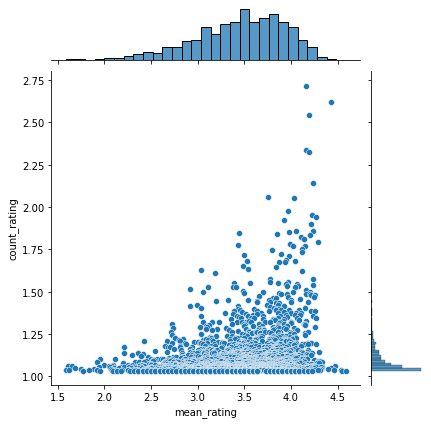

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
''' 
Popularity rankings:
Quality = Calculate the average rating of each film, sort and choose top values.
Popularity = Calculate a popularity metric based on the number of times each film has been rated. Many ratings = Popular
Combine popularity and quality

Recommend the 5 most popular films.


Item-based Collaborative Filtering:
Take a user_id as input
Check the movie the user has liked the most.
Output the top n most similar movies to that movie.

Recommend 5 films based on the user's favourite film or a film from input.

User-based Collaborative Filtering:
Recommend 5 films based on the user's similarity to other users.

'''